In [1]:
from spec_id  import Stack_spec,Stack_model, Get_flux, Scale_model, Stack_gal_spec,Best_fit_model,Oldest_galaxy
from vtl.Readfile import Readfile
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sea
import numpy as np
from astropy.table  import Table
from astropy.io import fits,ascii
from glob import glob
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})

In [2]:
ids,speclist,lmass,rshift,rad,sig,comp=np.array(Readfile('masslist_mar22.dat',is_float=False))
lmass,rshift,rad,sig,comp=np.array([lmass,rshift,rad,sig,comp]).astype(float)

IDc=[]  # compact sample
IDd=[]  # diffuse sample

IDmL=[]  # low mass sample
IDmH=[]  # high mass sample

for i in range(len(ids)):
    if 0.11 < comp[i]:
        IDd.append(i)
    if 0.11 > comp[i]:
        IDc.append(i)
    if 10.931 > lmass[i]:
        IDmL.append(i)
    if 10.931 < lmass[i]:
        IDmH.append(i)

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

print len(IDc)
print len(IDd)

print len(IDmH)
print len(IDmL)

10
15
6
19


In [4]:
glist=glob('/Users/vestrada/Clear_data/extractions_nov_22/ERSPRIME/*39170*1D*')[:-1]

print glist

['/Users/vestrada/Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-19-122-G102_39170.1D.fits', '/Users/vestrada/Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-20-092-G102_39170.1D.fits', '/Users/vestrada/Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-21-092-G102_39170.1D.fits', '/Users/vestrada/Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-22-142-G102_39170.1D.fits', '/Users/vestrada/Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-23-142-G102_39170.1D.fits']


In [6]:
def Stack_galaxy(spec, wv):
    flgrid = np.zeros([len(spec), len(wv)])
    errgrid = np.zeros([len(spec), len(wv)])
    for i in range(len(spec)):
        wave, flux, error = Get_flux(spec[i])
        mask = np.array([wave[0] < U < wave[-1] for U in wv])
        ifl = interp1d(wave, flux)
        ier = interp1d(wave, error)
        flgrid[i][mask] = ifl(wv[mask])
        errgrid[i][mask] = ier(wv[mask])
    ################

    flgrid = np.transpose(flgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / np.sum(weigrid[i])
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################

    IDX = [U for U in range(len(wv)) if stack[U] > 0]

    return wv[IDX], stack[IDX], err[IDX]

In [8]:
def Get_flux(FILE):
    observ = fits.open(FILE)
    w = np.array(observ[1].data.field('wave'))
    f = np.array(observ[1].data.field('flux')) * 1E-17
    sens = np.array(observ[1].data.field('sensitivity'))
    contam = np.array(observ[1].data.field('contam')) * 1E-17
    e = np.array(observ[1].data.field('error')) * 1E-17
    f -= contam
    f /= sens
    e /= sens

    INDEX = []
    for i in range(len(w)):
        if  w[i] < 11900:
            INDEX.append(i)

    w = w[INDEX]
    f = f[INDEX]
    e = e[INDEX]

    for i in range(len(f)):
        if f[i] < 0:
            f[i] = 0

    return w, f, e

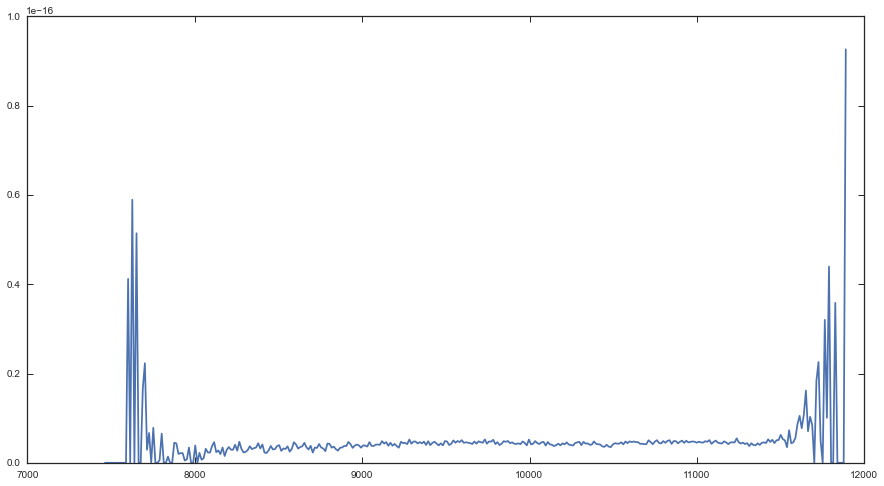

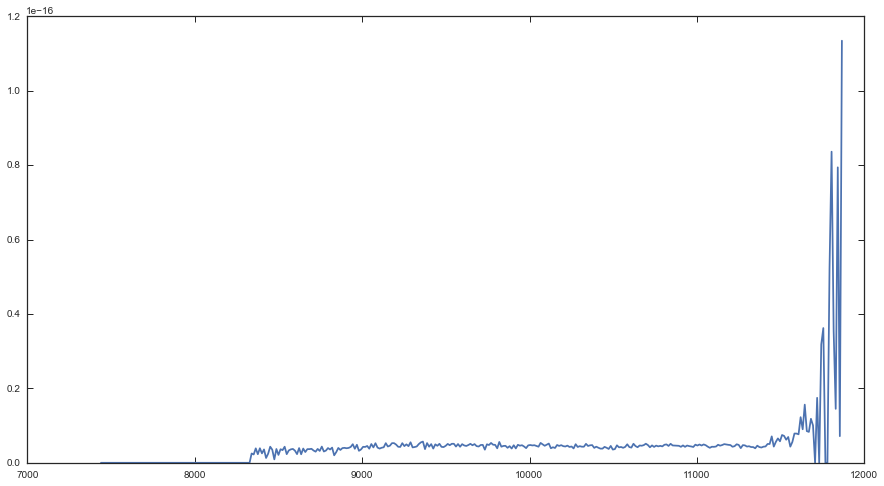

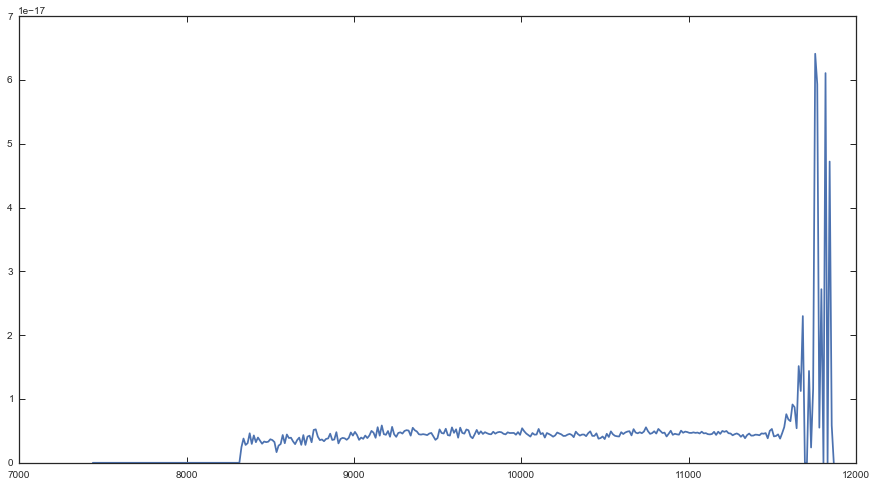

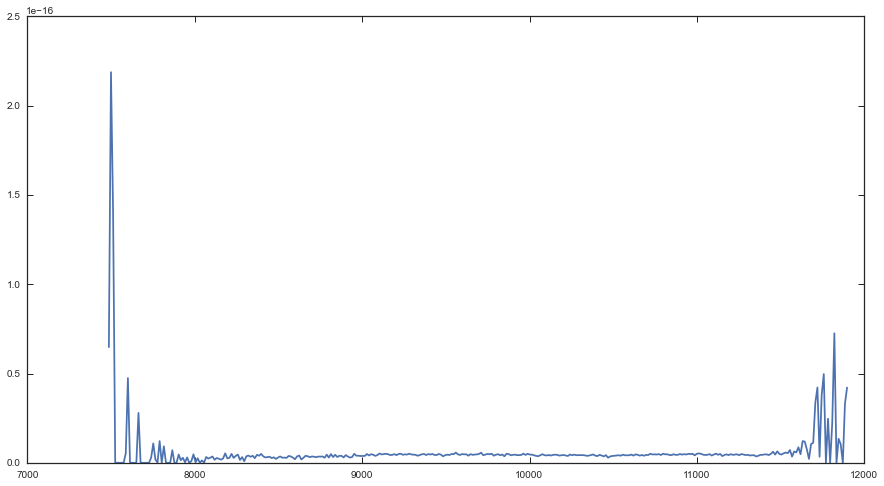

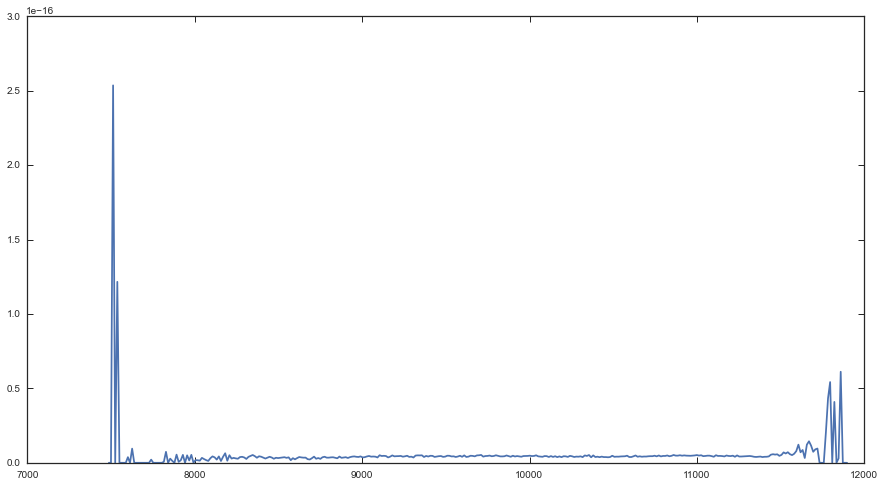

In [9]:
%matplotlib inline

for i in range(len(glist)):

    wv,fl,er=Get_flux(glist[i])
    
    plt.figure(figsize=[15,8])
    plt.plot(wv,fl)
    plt.show()
    plt.close()

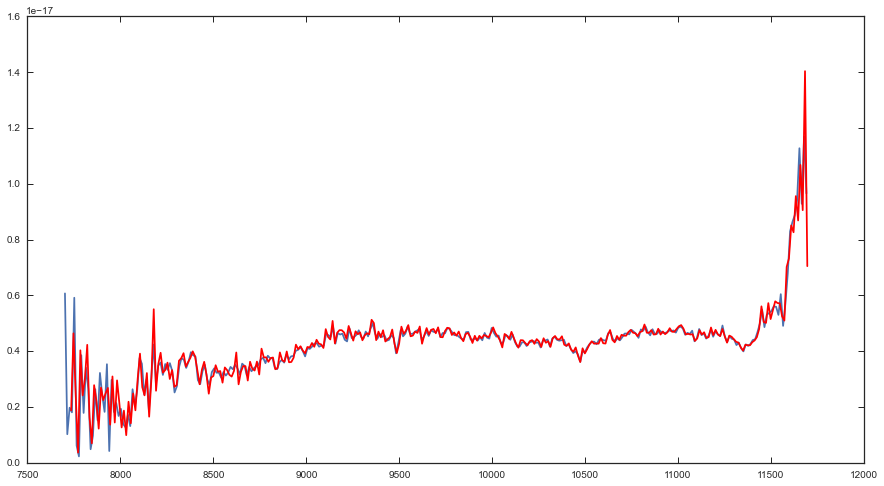

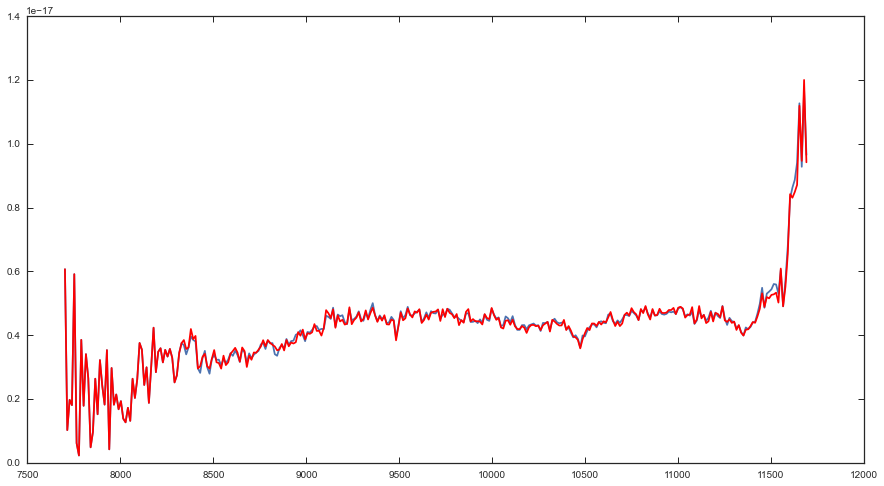

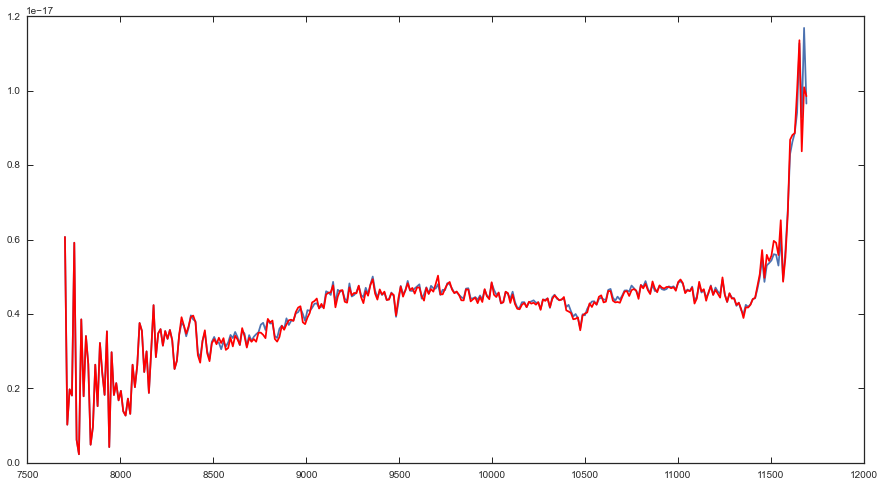

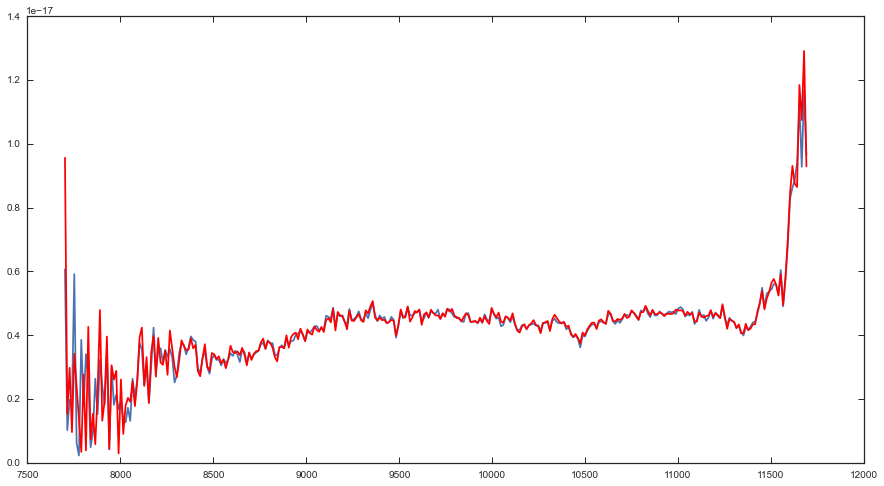

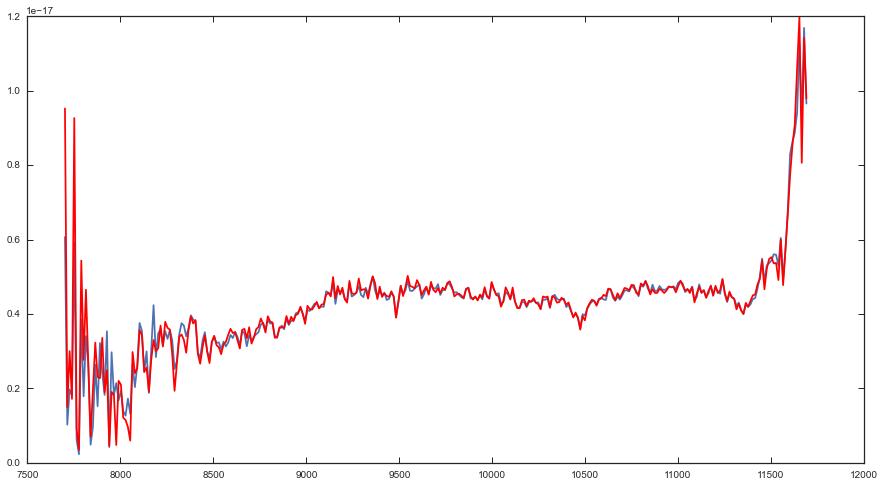

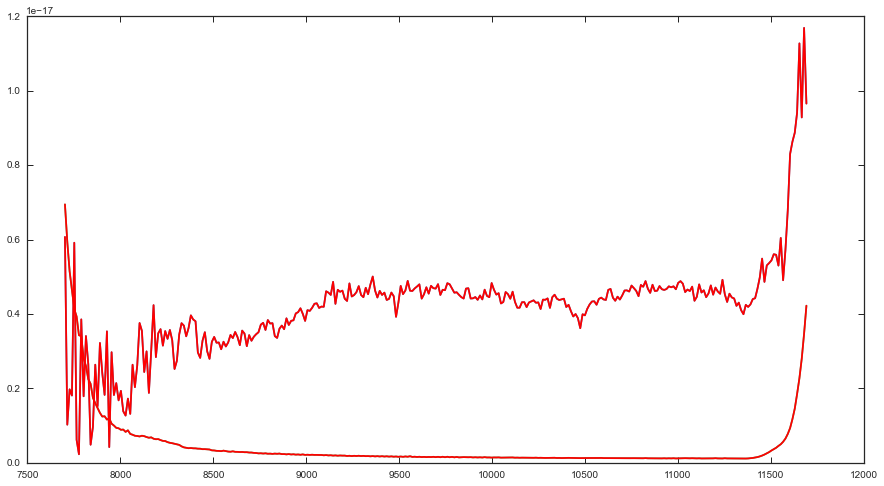

In [11]:
%matplotlib inline
wvo,flo,ero=np.load('spec_stacks_jan24/s39170_stack.npy')
for i in range(len(glist)):
    nglist=[]
    for ii in range(len(glist)):
        if glist[ii] != glist[i]:
            nglist.append(glist[ii])
    inwv,fl,er=Get_flux(nglist[0])
    IDwv=[]
    for iii in range(len(inwv)):
        if 7700 <= inwv[iii] <= 11700:
            IDwv.append(iii)

    wv,fl,er=Stack_galaxy(nglist,np.array(inwv)[IDwv])

    plt.figure(figsize=[15,8])
    plt.plot(wvo,flo)
    plt.plot(wv,fl,'r')
    plt.show()
    plt.close()
#     
inwv,fl,er=Get_flux(glist[0])
IDwv=[]
for iii in range(len(inwv)):
    if 7700 <= inwv[iii] <= 11700:
        IDwv.append(iii)
        
wv,fl,er=Stack_galaxy(glist,np.array(inwv)[IDwv])

# np.save('spec_stacks_jan24/s39170_stack',[wv,fl,er])

plt.figure(figsize=[15,8])
plt.plot(wvo,flo)
plt.plot(wvo,ero)
plt.plot(wv,fl,'r')
plt.plot(wv,er,'r')
plt.show()
plt.close()

[ 7958.89360164  7971.19557052  7983.4975394   7995.79950828  8008.10147715]
[ 7950.46305261  7962.66176129  7974.86046997  7987.05917865  7999.25788733]


[ 7952.27743342  7964.69076279  7977.10409217  7989.51742154  8001.93075092]

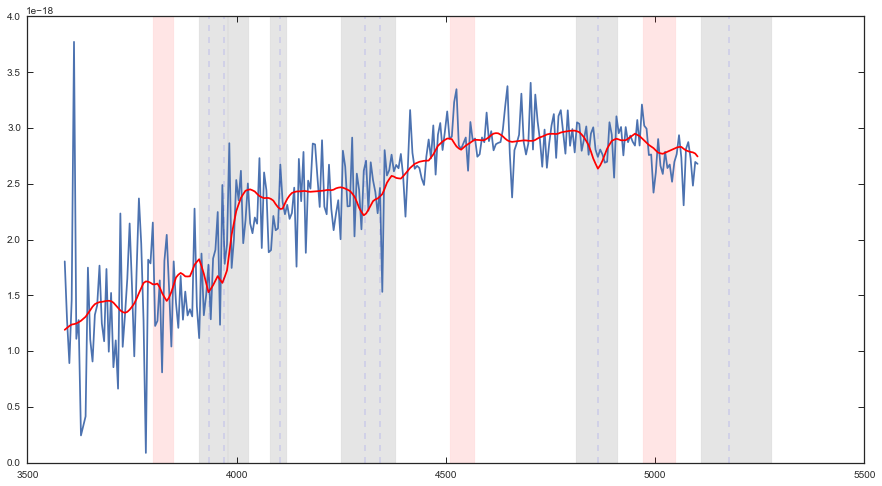

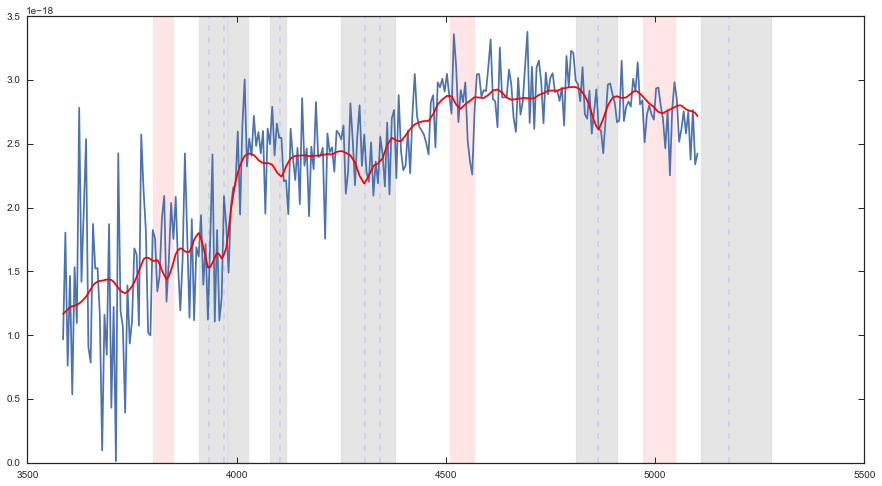

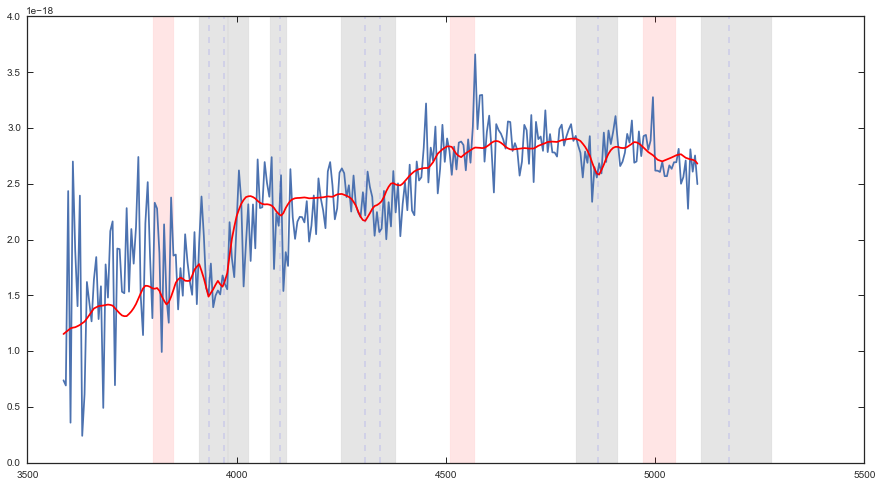

In [78]:
%matplotlib inline
wvo,flo,ero=np.load('spec_stacks_jan24/s40597_stack.npy')

inwv,fl,er=Get_flux(glist[0])
IDwv=[]
for iii in range(len(inwv)):
    if 7800 <= inwv[iii] <= 11500:
        IDwv.append(iii)
print inwv[:5]
wv1,fl1,er1=Stack_galaxy(glist[0:2],np.array(inwv)[IDwv])

inwv,fl,er=Get_flux(glist[2])
IDwv=[]
for iii in range(len(inwv)):
    if 7800 <= inwv[iii] <= 11500:
        IDwv.append(iii)
print inwv[:5]

wv2,fl2,er2=Stack_galaxy(glist[2:4],np.array(inwv)[IDwv])

inwv,fl,er=Get_flux(glist[4])
IDwv=[]
for iii in range(len(inwv)):
    if 7800 <= inwv[iii] <= 11500:
        IDwv.append(iii)
print inwv[:5]
       
wv3,fl3,er3=Stack_galaxy(glist[4:6],np.array(inwv)[IDwv])

np.save('spec_stacks_jan24/s40597_O1_stack',[wv1,fl1,er1])
np.save('spec_stacks_jan24/s40597_O2_stack',[wv2,fl2,er2])
np.save('spec_stacks_jan24/s40597_O3_stack',[wv3,fl3,er3])

# wv1,fl1,er1=Stack_galaxy(glist,np.arange(7900,11800,20))
mwv,mfl=np.load('../../../fsps_models_for_fit/galaxy_models/m0.006_a3.3_t8.48_z1.221_s40597_model.npy')
imfl1=interp1d(mwv,mfl)(wv1)
C1=Scale_model(fl1,er1,imfl1)
imfl2=interp1d(mwv,mfl)(wv2)
C2=Scale_model(fl2,er2,imfl2)
imfl3=interp1d(mwv,mfl)(wv3)
C3=Scale_model(fl3,er3,imfl3)


plt.figure(figsize=[15,8])
plt.plot(wv1/2.221,fl1,)
plt.plot(wv1/2.221,imfl1 * C1,'r')
plt.axvline(3934.777,linestyle='--', alpha=.1)
plt.axvline(3969.588,linestyle='--', alpha=.1)
plt.axvline(4102.89,linestyle='--', alpha=.1)
plt.axvline(4305.61,linestyle='--', alpha=.1)
plt.axvline(4341.68,linestyle='--', alpha=.1)
plt.axvline(4862.68,linestyle='--', alpha=.1)
plt.axvline(5176.7,linestyle='--', alpha=.1)
plt.axvspan(3800, 3850, color='r', alpha=.1)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4510, 4570, color='r', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(4970, 5050, color='r', alpha=.1)
plt.axvspan(5110, 5280, color='k', alpha=.1)
plt.show()
plt.close()

plt.figure(figsize=[15,8])
plt.plot(wv2/2.221,fl2,)
plt.plot(wv2/2.221,imfl2 * C2,'r')
plt.axvline(3934.777,linestyle='--', alpha=.1)
plt.axvline(3969.588,linestyle='--', alpha=.1)
plt.axvline(4102.89,linestyle='--', alpha=.1)
plt.axvline(4305.61,linestyle='--', alpha=.1)
plt.axvline(4341.68,linestyle='--', alpha=.1)
plt.axvline(4862.68,linestyle='--', alpha=.1)
plt.axvline(5176.7,linestyle='--', alpha=.1)
plt.axvspan(3800, 3850, color='r', alpha=.1)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4510, 4570, color='r', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(4970, 5050, color='r', alpha=.1)
plt.axvspan(5110, 5280, color='k', alpha=.1)
plt.show()
plt.close()

plt.figure(figsize=[15,8])
plt.plot(wv3/2.221,fl3,)
plt.plot(wv3/2.221,imfl3 * C3,'r')
plt.axvline(3934.777,linestyle='--', alpha=.1)
plt.axvline(3969.588,linestyle='--', alpha=.1)
plt.axvline(4102.89,linestyle='--', alpha=.1)
plt.axvline(4305.61,linestyle='--', alpha=.1)
plt.axvline(4341.68,linestyle='--', alpha=.1)
plt.axvline(4862.68,linestyle='--', alpha=.1)
plt.axvline(5176.7,linestyle='--', alpha=.1)
plt.axvspan(3800, 3850, color='r', alpha=.1)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4510, 4570, color='r', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(4970, 5050, color='r', alpha=.1)
plt.axvspan(5110, 5280, color='k', alpha=.1)
plt.show()
plt.close()

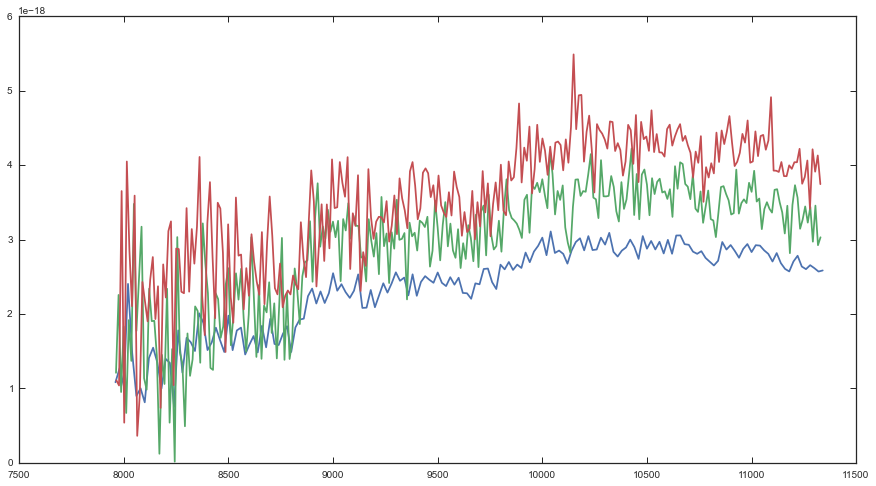

In [75]:
plt.figure(figsize=[15,8])
plt.plot(wv1,fl1)
plt.plot(wv2,fl2*1.25)
plt.plot(wv3,fl3*1.5)
plt.show()
plt.close()

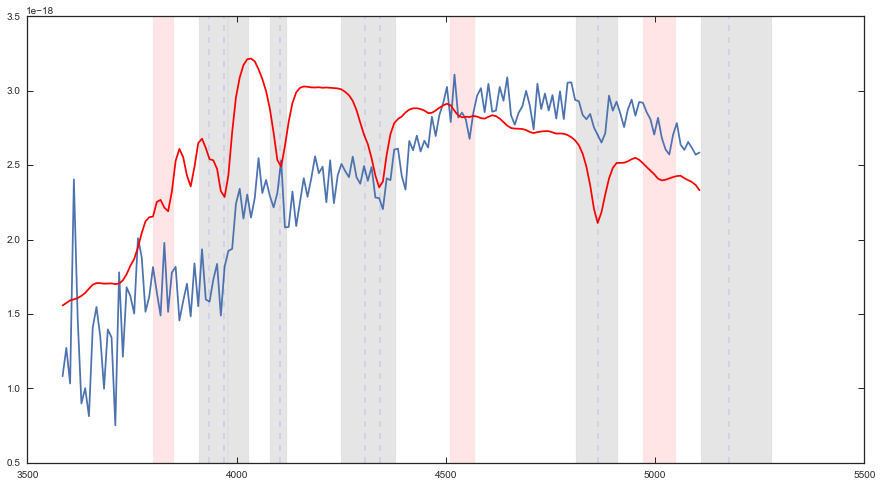

In [69]:
wvo,flo,ero=np.load('spec_stacks_jan24/s40597_stack.npy')

wv1,fl1,er1=Stack_galaxy(glist,np.arange(7900,11800,20))
mwv,mfl=np.load('../../../fsps_models_for_fit/galaxy_models/m0.019_a1.0_t8.48_z1.221_s40597_model.npy')
imfl=interp1d(mwv,mfl)(wv1)
C=Scale_model(fl1,er1,imfl)

plt.figure(figsize=[15,8])
# plt.plot(wvo,flo)
plt.plot(wv1/2.221,fl1,)
plt.plot(wv1/2.221,imfl * C,'r')
plt.axvline(3934.777,linestyle='--', alpha=.1)
plt.axvline(3969.588,linestyle='--', alpha=.1)
plt.axvline(4102.89,linestyle='--', alpha=.1)
plt.axvline(4305.61,linestyle='--', alpha=.1)
plt.axvline(4341.68,linestyle='--', alpha=.1)
plt.axvline(4862.68,linestyle='--', alpha=.1)
plt.axvline(5176.7,linestyle='--', alpha=.1)
plt.axvspan(3800, 3850, color='r', alpha=.1)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4510, 4570, color='r', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(4970, 5050, color='r', alpha=.1)
plt.axvspan(5110, 5280, color='k', alpha=.1)
plt.show()
plt.close()

In [8]:
max_age = Oldest_galaxy(1.344)
print max_age
print age[len(age[age <=max_age]):]

5.11784097528
[ 5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6. ]
